In [282]:
import os, shutil, gdal
import numpy as np
import rasterio as rio

from math import pi

from skimage.morphology import square,diamond,ball, disk
from scipy.ndimage.filters import generic_filter

from numba import njit

from datetime import datetime

from joblib import Parallel, delayed

from scipy import ndimage as ndi
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, binary_erosion, remove_small_objects

In [7]:
loc_dsm = '../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm/'
dsms = [os.path.join(loc_dsm,f) for f in os.listdir(loc_dsm) if f.endswith(".tif")]

#overviews = Parallel(n_jobs=10, verbose=30)(delayed(developOverviews)(dsm) for dsm in dsms)

In [122]:
def calcSlopes(infile, odir, overwrite=False):
    infile = os.path.abspath(infile)
    ofile = os.path.basename(infile).replace(".tif", "_slope.tif")
    outfile = os.path.join(odir, ofile)
    if not os.path.exists(outfile) or overwrite:
        #gdaldem_cmd = f"""gdaldem slope -p -co "COMPRESS=LZW" -co "TILED=TRUE" {infile} {outfile}"""
        #os.system(gdaldem_cmd)
        opts = dict(slopeFormat="percent",
                    creationOptions=['COMPRESS=LZW','TILED=YES'])
        gdal.DEMProcessing(outfile, infile, 'slope', **opts)
    return outfile

@njit(fastmath=True)
def windowMean(a):
    return np.mean(a)

def getMeanWindow(arr, winsize):
    out = generic_filter(arr, windowMean, footprint=diamond(winsize), mode='mirror')
    return out

slope_dir = "../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_Slope"
os.makedirs(slope_dir, exist_ok=True)
#slopes = Parallel(n_jobs=6, verbose=5)(delayed(calcSlopes)(dsm, slope_dir, overwrite=False) for dsm in dsms)


In [205]:
test_array = np.array([[2395.83876464272, 2395.96472993846, 2396.85090469573, 2395.96472993846, 2395.83876464272],[ 2395.96472993846, 2395.83876464272, 2396.61425200838, 2397.39407554941, 2396.61425200838],[ 2396.06672131951, 2395.96472993846, 2396.71296956122, 2397.51114657062, 2395.96472993846],[ 2395.83876464272, 2396.06672131951, 2396.85090469573, 2397.5728539882, 2397.5728539882],[ 2395.96472993846, 2395.83876464272, 2395.96472993846, 2396.06672131951, 2396.71296956122]])
#computeTRI(test_array, 2)

In [183]:
test_array[:,:] = 0
test_array[2,2] = 3
test_array

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [186]:
(4).shape

(4, 4)

In [290]:
@njit(fastmath=True)
def windowTRI(a):
    shp = a.shape
    mm = round(a.shape[0]/2)
    centralVal = a[mm]
    diff = np.absolute(a-centralVal)
    average = np.mean(diff)
    total_size = shp[0]
    tri = average*(total_size)/(total_size-1)
    return tri

def computeTRI(arr, winsize):
    if winsize % 2 == 0:
        raise ValueError("Bad window size. Must be odd number")
    out = generic_filter(arr, windowTRI, footprint=square(winsize), mode='mirror', cval=0)
    return out

#tri_test = computeTRI(test_array, 5)
#tri_test[2,2]
for dsm in dsms:
    if "E1000_N470" not in dsm:
        continue
    with rio.open(dsm) as ras:
        msk = ras.read_masks(1)
        dsm_array = ras.read(1)
        dsm_array[msk==0] = np.NaN
        kwargs = ras.profile

    tri = computeTRI(dsm_array, 501)
    tri[msk==0] = np.NaN
    ofile = os.path.basename(dsm).replace(".tif","_testTRI.tif")
    with rio.open(ofile, 'w', **kwargs) as oras:
        oras.write(tri, 1)                 
    break
    
    selem = disk(2)

    edges = np.where(tri > 1, 0, 1)
    #edges = closing(edges, selem)
    filled = ndi.binary_fill_holes(edges)
    filled[msk==0] = np.NaN
    kwargs.update(dtype=np.uint8, nodata=255)

    
    with rio.open(ofile, 'w', **kwargs) as oras:
        oras.write(tri.astype(np.uint8), 1)

MemoryError: 

In [242]:
from skimage.segmentation import watershed, quickshift
with rio.open(dsm) as src:
    dsm_arr = src.read(1)
watershedlabels = watershed(dsm_arr, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)
kwargs.update(dtype=np.int32)
with rio.open("./watershed.tif", "w", **kwargs) as dst:
    dst.write(watershedlabels, 1)

In [ ]:
kwargs.update(dtype=np.int32)
with rio.open("./quickshift.tif", "w", **kwargs) as dst:
    dst.write(watershedlabels, 1)

'./E1000_N470_DSM80cm_testTRI_FillT1DS1.tif'

In [29]:
ned_tifs = [os.path.join("../OtherData/elevation_NED30M/", os.path.basename(f)) for f in os.listdir("../OtherData/elevation_NED30M/") if f.endswith(".tif")]
ned_slope_dir = "../OtherData/elevation_NED30M_Slope"
os.makedirs(ned_slope_dir, exist_ok=True)
slopes = Parallel(n_jobs=4, verbose=5)(delayed(calcSlopes)(ned_tif, ned_slope_dir, overwrite=False) for ned_tif in ned_tifs)
gdalbuildvrt_cmd = f"""gdalbuildvrt {os.path.join(ned_slope_dir,'NED30m_Slope.vrt')} {' '.join(slopes)}"""
os.system(gdalbuildvrt_cmd)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f67815d39f0> >

In [212]:
def createTRI(infile, out_dir, overwrite=False):
    
    ofile  = os.path.basename(infile).replace(".tif", f"_TRI.tif")
    outfile = os.path.join(out_dir, ofile)
    if not os.path.exists(outfile) or overwrite:
        opts = dict(creationOptions=['COMPRESS=LZW','TILED=YES'])
        gdal.DEMProcessing(outfile, infile, 'TRI', **opts)
    return

loc_tri = f'../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_TRI'
os.makedirs(loc_tri, exist_ok=True)
triing = Parallel(n_jobs=12, verbose=5)(delayed(createTRI)(dsm, loc_tri, overwrite=False) for dsm in dsms)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 327 out of 327 | elapsed:    0.8s finished


1. Low TRI mean flatter, but could be a building rooftop or ground
2. For building rooftops, they are characterized by high variance of TRI across the larger radius radius. 300ft would be maxium radial size of building (600 ft span)

In [16]:
@njit(fastmath=True)
def windowStd(a):
    return np.std(a)

def getStdDevWindow(arr, winsize):
    out = generic_filter(arr, windowStd, footprint=diamond(winsize), mode='mirror')
    return out

loc_tri = '../EPCExtent_30cm/Elevation_80cmNPS/DSM_TRI'
tris = [os.path.join(loc_tri,f) for f in os.listdir(loc_tri) if f.endswith(".tif")]

loc_triStdDev = '../EPCExtent_30cm/Elevation_80cmNPS/DSM_TRIStdDev'
os.makedirs(loc_triStdDev, exist_ok=True)

overwrite = True

count = 0
window_sizes = [30]
pairs = {}
for tri in tris:
    for window_size in window_sizes:
        ofile = os.path.join(loc_triStdDev, os.path.basename(tri).replace("_DSMTRI.tif", f"_DSMTRIStdDev{window_size}.tif"))
        pairs[tri] = ofile
        
def calcStdDevWindow(tri, ofile, overwrite=False):
    global count
    s0 = datetime.now()
    count += 1
    if os.path.exists(ofile) and not overwrite:
        return 0
    if "E1020_N430" not in ofile:# and "E0920_N470" not in ofile:
        return
    
    window_size = os.path.basename(ofile).split("_DSMTRIStDev")[1].split(".")[0]
    
    with rio.open(tri) as ras:
        msk = ras.read_masks(1)
        tri_array = ras.read(1)
        tri_array[msk==0] = np.NaN
        kwargs = ras.profile

    stddev_TRI = getStdDevWindow(tri_array, window_size)

    with rio.open(ofile, 'w', **kwargs) as oras:
        oras.write(stddev_TRI, 1)                 
    s1 = datetime.now()
    elapsed = s1-s0
    print(f"\t{elapsed}")
    print(f"{count} - Finished with {ofile}")

    return elapsed
        
time_lapse = Parallel(n_jobs=6)(delayed(calcStdDevWindow)(k, v) for k,v in pairs.items())

In [265]:
from skimage.morphology import binary_erosion, remove_small_objects

In [287]:
def developOverviews(file):
    os.system(f"gdalinfo -mm {file}")
    os.system(f"gdaladdo -clean {file}")
    os.system(f"gdaladdo -r average -ro --config COMPRESS_OVERVIEW LZW -minsize 8 {file}")
    
def fillTRIHoles(tri, odir, threshold, disk_size=2, overwrite=False):
    ofile = os.path.join(odir, os.path.basename(tri).replace(".tif", f"_FillT{threshold}DS{disk_size}.tif"))
    if os.path.exists(ofile) and not overwrite:
        return ofile
    
    with rio.open(tri) as ras:
        tri_data = ras.read(1)
        mask = ras.read_masks(1)
        kwargs = ras.profile
    
    #secondPercentile = np.percentile(test[mask!=0],2)
    #ninetyeightPercentile = np.percentile(test[mask!=0],98)
    #edge_limit = ninetyeightPercentile-((ninetyeightPercentile-secondPercentile)/2)
    
    
    # threshold edges to yes or no
    edges = np.where(tri_data <= threshold, 0, 1)
    
    #close 
    edges = closing(edges, disk(disk_size))
    # fill regions completely enclosed
    filled = ndi.binary_fill_holes(edges)
    # Erode filled holes
    filled = binary_erosion(filled, selem=square(5))
    
    # remove small regions of isolated edges. Regions smaller than the smallest window used in DTM generation do not need to exist
    #filled = remove_small_objects(filled.astype(bool), min_size=pi*(13*13), connectivity=0)

    edges[mask==0] = 1

    kwargs.update(dtype=np.uint8, nodata=255)
    with rio.open(ofile, 'w', **kwargs) as dst:
        dst.write(filled.astype(np.uint8),1)
        
    developOverviews(ofile)
    
    return ofile

In [288]:
fillTRIHoles(ofile, "./", 1, disk_size=1, overwrite=True)
fillTRIHoles(ofile, "./", 1, disk_size=0, overwrite=True)

'./E1000_N470_DSM80cm_testTRI_FillT1DS0.tif'

In [74]:
tri_loc = '../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_TRI'
triFilled_loc = '../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_TRI_filled'
os.makedirs(loc_triFilled, exist_ok=True)
dsm_tri = [os.path.join(tri_loc,f) for f in os.listdir(tri_loc) if f.endswith(".tif")]
# TRI value is the mean of the difference of a cell and the cells surrounding it
tri_filled = Parallel(n_jobs=5, verbose=5)(delayed(fillTRIHoles)(tri_file, triFilled_loc, threshold=1, disk_size=2, overwrite=False) for tri_file in dsm_tri)
filledVRT_cmd = """gdalbuildvrt ../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_TRI_filled/TRI80cmFilled_2019.vrt ../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm_TRI_filled/*.tif"""
os.system(filledVRT_cmd)
print("FINISHED")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 327 out of 327 | elapsed:    0.6s finished


FINISHED


In [133]:
from skimage import filters

def getEdges(file, odir="../EPCExtent_30cm/Elevation_80cmNPS/DSM_edges", ftype='sobel'):
    os.makedirs(odir, exist_ok=True)
    
    with rio.open(file) as src:
        data = src.read(1)
        kwargs = src.profile
    
    edges={}
    edges['sobel'] = filters.sobel(data)
    edges['scharr'] = filters.scharr(data)
    edges['prewitt'] = filters.prewitt(data)
    
    kwargs.update(dtype=np.float32)
    ofile = os.path.basename(file).replace(".tif",f"_{ftype}.tif")
    with rio.open(os.path.join(odir,ofile), 'w', **kwargs) as dst:
        dst.write(edges[ftype].astype(np.float32),1)
        
getEdges("../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm/E0980_N470_DSM80cm.tif", ftype='sobel')

<Figure size 432x288 with 0 Axes>

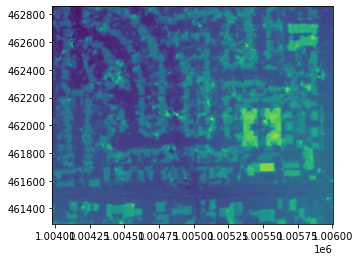

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Felzenszwalb number of segments: 615
SLIC number of segments: 249


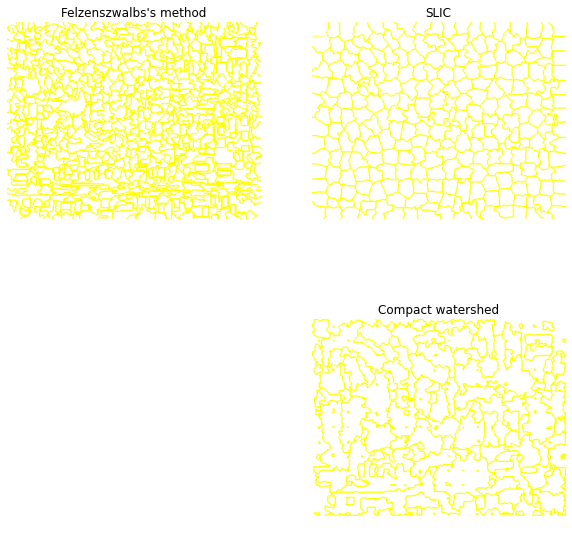

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from rasterio.plot import show
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

def segmentImage(filepath):
    with rio.open(filepath) as src:
        img = src.read(1)
        show(src)
        
    
    segments_fz = felzenszwalb(img, scale=20, sigma=0.5, min_size=50)
    segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
    #segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    gradient = sobel(rgb2gray(img))
    segments_watershed = watershed(gradient, markers=250, compactness=0.001)

    print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
    print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
    #print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].imshow(mark_boundaries(img, segments_fz))
    ax[0, 0].set_title("Felzenszwalbs's method")
    ax[0, 1].imshow(mark_boundaries(img, segments_slic))
    ax[0, 1].set_title('SLIC')
    ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
    ax[1, 1].set_title('Compact watershed')

    for a in ax.ravel():
        a.set_axis_off()

plt.tight_layout()
plt.show()
    
segmentImage('../TempData/E1000_N470_part.tif')

In [5]:
   
#time_lapse = Parallel(n_jobs=3)(delayed(developOverviews)(v) for k,v in pairs.items())



with rio.open("../EPCExtent_30cm/Elevation_80cmNPS/DSM_TRI/E1020_N510_DSMTRI.tif") as ras:
    test = ras.read(1)
    mask = ras.read_masks(1)
    #test[mask!=0] = np.NaN
    kwargs = ras.profile
    
    secondPercentile = np.percentile(test[mask!=0],2)
    ninetyeightPercentile = np.percentile(test[mask!=0],98)
    edge_limit = ninetyeightPercentile-((ninetyeightPercentile-secondPercentile)/2)

disk_size = 3
selem = disk(disk_size)
selem

edges = np.where(test <= 1, 0, 1)
edges = closing(edges, selem)
edges = closing(edges, selem)
filled = ndi.binary_fill_holes(edges)
edges[mask==0] = 1



kwargs.update(dtype=np.uint8, nodata=255)
with rio.open(f"../EPCExtent_30cm/Elevation_80cmNPS/E1020_N510_DSMTRI_filled_{disk_size}.tif", 'w', **kwargs) as dst:
    dst.write(filled.astype(np.uint8),1)

In [47]:
def getStats(raster):
    src_ds = gdal.Open(raster)
    print("[ RASTER BAND COUNT ]: ", src_ds.RasterCount)
    for band in range( src_ds.RasterCount ):
        band += 1
        print("[ GETTING BAND ]: ", band)
        srcband = src_ds.GetRasterBand(band)
        if srcband is None:
            continue

        stats = srcband.GetStatistics( False, True )
        if stats is None:
            continue

        rmin = stats[0]
        rmax = stats[1]
        rmean = stats[2]
        rstddev = stats[3]

        print("[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % (rmin, rmax, rmean, rstddev ))
        return (rmin, rmax, rmean, rstddev)

In [51]:
rstddev/2+rmean

1.38423432049608

In [53]:
range_min = rmean-(2*rstddev)
range_max =  rmean+(2*rstddev)
rng = range_max - range_min
print(f"min: {range_min}\nmax: {range_max}")

min: -0.64712210189416
max: 1.5394324079500399


In [47]:
rstddev = 0.54663862746105
nrmax = 0.44615515302794 + (2*rstddev)
nrmax
nrmin = 0.44615515302794 - (2*rstddev)
nrmax,nrmin

(1.5394324079500399, -0.64712210189416)

In [54]:
print(range_min + (1*rng/5))
print(range_min + (2*rng/5))
print(range_min + (3*rng/5))
print(range_min + (4*rng/5))
print(range_min + (5*rng/5))

-0.20981119992532
0.22749970204352
0.66481060401236
1.1021215059812
1.5394324079500399


In [38]:
0.617745778416088 - 0.264867450210032

0.352878328206056

In [41]:
(1.3235--0.440889)/5

0.3528778